# ACS PubCov Experiment

In [24]:
# Load all necessary packages
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import folktables
from folktables import ACSDataSource
import matplotlib.pyplot as plt
from balancers import BinaryBalancer
from tqdm import tqdm
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import os
sns.set_theme()

In [25]:
# Necessary functions 
def public_coverage_filter(data):
    """
    Filters for the public health insurance prediction task; focus on low income Americans, and those not eligible for Medicare
    """
    df = data
    df = df[df['AGEP'] < 65]
    df = df[df['PINCP'] <= 30000]
    return df

In [26]:
# Set relevant variables
results_dir = 'results/'

state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

ACStask = folktables.BasicProblem(
    features=[
        'AGEP',
        'SCHL',
        'MAR',
        'DIS',
        'ESP',
        'CIT',
        'MIG',
        'MIL',
        'ANC',
        'NATIVITY',
        'DEAR',
        'DEYE',
        'DREM',
        'PINCP',
        'ESR',
        'FER',
        'RAC1P',
    ],
    target='PUBCOV',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=public_coverage_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [27]:
# Load state data
state = "CA"
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states =[state], download=True)
x, y, a = ACStask.df_to_numpy(acs_data)
a = (a == 1)*1

# Split data
x_train, x_test, y_train, y_test, a_train, a_test = train_test_split( 
    x, y, a, test_size=0.25, random_state=0)

# RF classifier for Y
y_model = RandomForestClassifier(max_depth=10)
y_model.fit(x_train, y_train)
y_hat = y_model.predict(x_test)

# RF classifier for A
a_model = RandomForestClassifier(max_depth=10)
a_model.fit(x_train, a_train)
a_hat = a_model.predict(x_test)

In [28]:
# Run experiment
iter = 1000
y = y_test
a = a_test
num_rows = len(a)

d_tpr = []
d_fpr = []
d_tpr_fair = []
d_fpr_fair = []
d_tpr_opt = []
d_fpr_opt = []

b_tpr = []
b_fpr = []
th_b_tpr_fair = []
th_b_fpr_fair = []
ac_b_tpr_fair = []
ac_b_fpr_fair = []
th_b_tpr_opt = []
th_b_fpr_opt = []
ac_b_tpr_opt = []
ac_b_fpr_opt = []

o_loss = []
fair_loss = []
opt_loss = []
k = 0 


while k < iter:
    random_indices = np.random.choice(num_rows, size=num_rows, replace=True)
    a_s = a[random_indices]
    y_s = y[random_indices]
    a_hat_s = a_hat[random_indices]
    y_hat_s = y_hat[random_indices]
    true_balancer = BinaryBalancer(y=y_s, y_=y_hat_s, a=a_s, a_hat = a_hat_s, adjusted = False)

    # See if conditions for assumption are met
    # If not, project classifier onto feasible set
    if true_balancer.assumption == 0:
        true_balancer.adjust(con = 'tpr/fpr', obj = 'project')
        true_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)
    
    # P(Y = 0) and P(Y=1)
    p0 = true_balancer.overall_rates.num_neg
    p1 = true_balancer.overall_rates.num_pos

    # Measure true bias
    d_tpr.append(np.abs(true_balancer.a_gr_list[1].tpr - true_balancer.a_gr_list[0].tpr))
    d_fpr.append(np.abs(true_balancer.a_gr_list[1].fpr - true_balancer.a_gr_list[0].fpr))

    # Calculate worst case fairness violations
    b_tpr.append(np.max([np.abs(true_balancer.bounds['tpr']['ub']), np.abs(true_balancer.bounds['tpr']['lb'])]))
    b_fpr.append(np.max([np.abs(true_balancer.bounds['fpr']['ub']), np.abs(true_balancer.bounds['fpr']['lb'])]))
    o_loss.append(p0*p1*(1 - true_balancer.overall_rates.tpr  + true_balancer.overall_rates.fpr))

    # Adjust by enforcing fairness with respect to A_hat
    true_balancer.adjust(con = 'tpr', obj = 'fair')
    fair_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)

    # Calculate new true fairness violations
    d_tpr_fair.append(np.abs(fair_balancer.a_gr_list[1].tpr - fair_balancer.a_gr_list[0].tpr))
    d_fpr_fair.append(np.abs(fair_balancer.a_gr_list[1].fpr - fair_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    th_b_tpr_fair.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_fair.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    ac_b_tpr_fair.append(np.max([np.abs(fair_balancer.bounds['tpr']['ub']), np.abs(fair_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_fair.append(np.max([np.abs(fair_balancer.bounds['fpr']['ub']), np.abs(fair_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    fair_loss.append(p0*p1*(1 - fair_balancer.overall_rates.tpr + fair_balancer.overall_rates.fpr))

    # Adjust optimally
    true_balancer.adjust(con = 'tpr', obj = 'opt')
    opt_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)

    # Calculate new true fairness violations
    d_tpr_opt.append(np.abs(opt_balancer.a_gr_list[1].tpr - opt_balancer.a_gr_list[0].tpr))
    d_fpr_opt.append(np.abs(opt_balancer.a_gr_list[1].fpr - opt_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    th_b_tpr_opt.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_opt.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    ac_b_tpr_opt.append(np.max([np.abs(opt_balancer.bounds['tpr']['ub']), np.abs(opt_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_opt.append(np.max([np.abs(opt_balancer.bounds['fpr']['ub']), np.abs(opt_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    opt_loss.append(p0*p1*(1 - opt_balancer.overall_rates.tpr  + opt_balancer.overall_rates.fpr))

    if k%200 == 0:
        print(k)
    k = k+1 

0
200
400
600
800


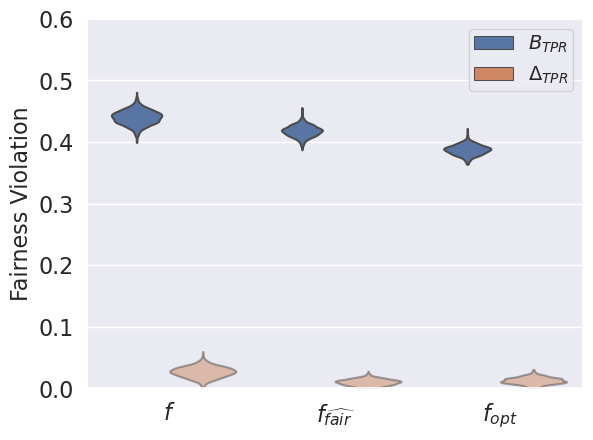

In [29]:
# Plotting theoretical tpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + th_b_tpr_fair + th_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
                hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
plt.ylim([0,0.6])
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir, state + '_theo_b_tpr.pdf'),bbox_inches="tight")

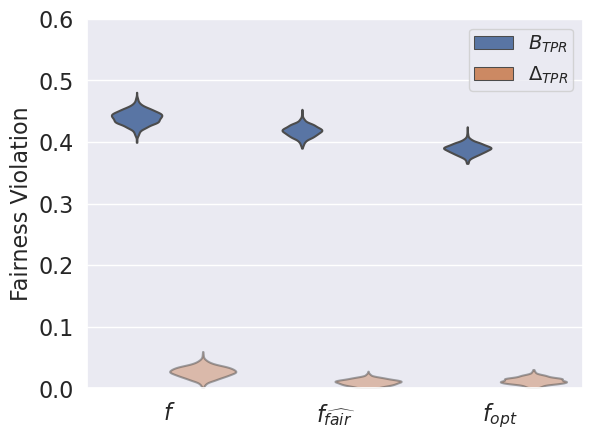

In [30]:
# Plotting actual tpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + ac_b_tpr_fair + ac_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
                hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
plt.ylim([0,0.6])
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir, state + '_ac_tpr.pdf'),bbox_inches="tight")

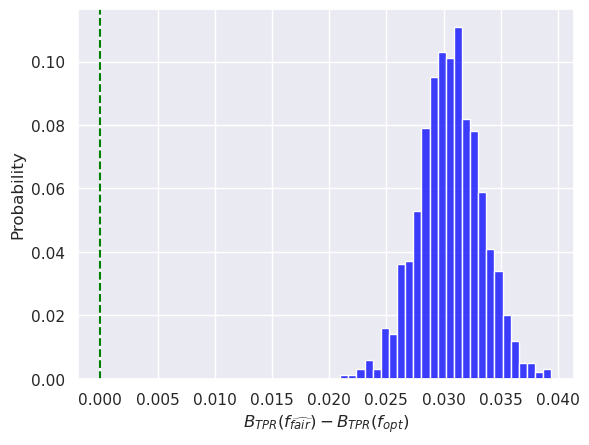

In [31]:
# Difference between theoretical tpr bounds
diff = np.array(th_b_tpr_fair) - np.array(th_b_tpr_opt)
sns.histplot(diff, stat = 'probability', color = 'blue')
plt.xlabel(r'$B_{TPR}(f_{\widehat{fair}}) - B_{TPR}(f_{opt})$')
plt.axvline(0, linestyle = '--', color = 'green')
plt.savefig(os.path.join(results_dir, 'b_tpr_diff.pdf'),bbox_inches="tight")

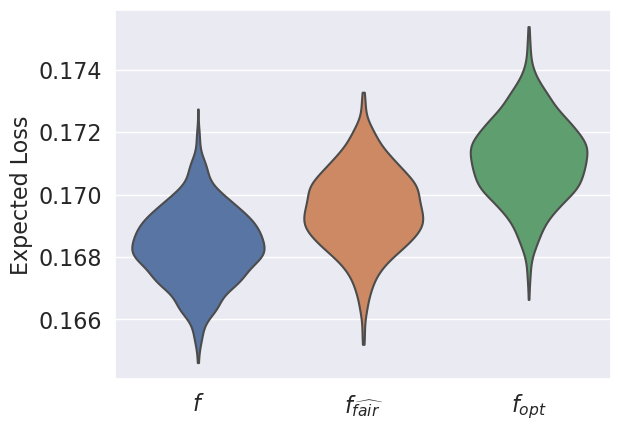

In [32]:
# Plotting expected loss
method =  [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
losses = o_loss + fair_loss + opt_loss
loss_df = pd.DataFrame(list(zip(losses, method)), columns =['Expected Loss', 'Classifier'])
sns.violinplot(data=loss_df, x = 'Classifier', y = 'Expected Loss', cut = 0, inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Expected Loss', fontsize=16)
plt.savefig(os.path.join(results_dir, state + '_loss.pdf'),bbox_inches="tight")